In [1]:
import numpy as np

import mlgrad.model as model
import mlgrad.loss as loss
import mlgrad.func as func

from mlgrad import erm_fg, erm_irgd, fg, weights, averager_it, erisk2, sg, erm_sg

from pprint import pprint

from axon import loads, dumps
from sklearn.datasets import load_digits
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

from random import randint

In [2]:
digits = load_digits()
X, Y = digits.data, digits.target
print(X.shape)
scaler = MinMaxScaler()
Xt = scaler.fit_transform(X)

(1797, 64)


In [3]:
def sigma_neuron_layer(n_input, n):
    layer = model.ModelLayer(n_input)
    for i in range(n):
        mod = model.SigmaNeuronModel(func.Arctang(), n_input)
        layer.add(mod)
    return layer

def linear_neuron_layer(n_input, n):
    layer = model.ModelLayer(n_input)
    for i in range(n):
        mod = model.LinearModel(n_input)
        layer.add(mod)
    return layer

In [4]:
def binarize(Y, n):
    N = len(Y)
    data = np.zeros((N,n), 'd')
    rows = []
    for k in range(N):
        data[k, Y[k]] = 1
    data = 2*data-1
    return data

Ys = binarize(Y, 10)
print(Ys.shape, Xt.shape)

(1797, 10) (1797, 64)


In [5]:
result = {}

In [6]:
n_input = 64
n_hidden = 20
def create_nn(n_input = 64, n_hidden = 30):
    layer1 = sigma_neuron_layer(n_input, n_hidden)
    layer2 = linear_neuron_layer(n_hidden, 10)

    ffnn = model.FFNetworkModel()
    ffnn.add(layer1)
    ffnn.add(layer2)

    ffnn.allocate()
    return ffnn

def clf_func(ffnn, x):
    return np.argmax(np.sign(ffnn(x)))

def margin_func(ffnn, x, y):
    u = ffnn(x)
    j =  np.argmax(np.sign(u))
    if j == y:
        return np.abs(u[j])
    else:
        return -np.abs(u[j])        

In [7]:
q = 0.50
Q = int(100*q)

N = len(Y)
N_q = int(q*N)

rep_dict = {0:8, 1:7, 2:7, 3:8, 4:9, 5:6, 6:8, 7:1, 8:0, 9:8}

Y_o = Y.copy()
Is = np.random.permutation(range(N))

for i in Is[:N_q]:
    Y_o[i] = rep_dict[Y_o[i]]

Ys_o = binarize(Y_o, 10)

print(N_q, np.sum(Y_o != Y), np.sum(Ys_o != Ys)//2)

898 898 898


In [8]:
ffnn0 = create_nn(n_input, n_hidden)
ffnn0.param[:] = np.random.random(size=ffnn0.n_param)

In [9]:
ffnn1 = create_nn(n_input, n_hidden)
ffnn1.param[:] = np.random.random(size=ffnn1.n_param)

In [45]:
ffnn2 = create_nn(n_input, n_hidden)
ffnn2.param[:] = np.random.random(size=ffnn2.n_param)

In [44]:
loss_func0 = loss.MarginMultLoss(func.Hinge(1.0))
er0 = erisk2(Xt, Ys_o, ffnn0, loss_func0)
fg0 = erm_fg(er0, h=0.001, tol=1.0e-6, n_iter=1000)

682 [0.11007955 0.99940696 0.12792146 ... 0.10235137 0.02170927 0.16635137]


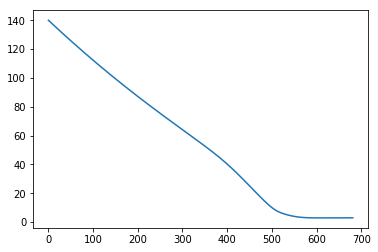

In [46]:
plt.plot(fg0.lvals)

In [47]:
np.sum([clf_func(ffnn0, x) == y for x,y in zip(Xt,Y)])/len(Y)

0.09905397885364496

In [ ]:
loss_func1 = loss.MarginMultLoss(func.Hinge(1.0))
er1 = erisk2(Xt, Ys_o, ffnn1, loss_func1)
fg1 = erm_fg(er1, h=0.001, tol=1.0e-6, n_iter=1000)

In [ ]:
plt.plot(fg1.lvals)

In [ ]:
np.sum([clf_func(ffnn1, x) == y for x,y in zip(Xt,Y)])/len(Y)

In [52]:
loss_func2 = loss.MarginMultLoss(func.Hinge())
er2 = erisk2(Xt, Ys_o, ffnn2, loss_func2)
fg2 = fg(er2, h=0.1, tol=1.0e-5, n_iter=1000)
avg2 = averager_it(func.QuantileFunc(0.6, func.Sqrt(1.0)))
wg2 = weights.MWeights(avg2, er2)
alg = erm_irgd(fg2, wg2, n_iter=12)

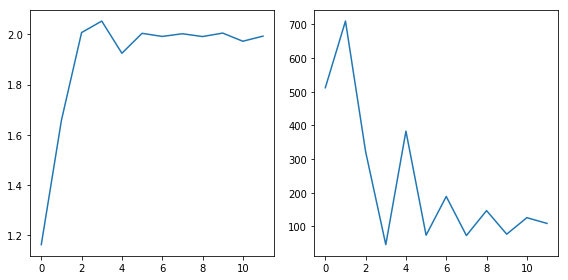

In [53]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(alg.lvals)
plt.subplot(1,2,2)
plt.plot(alg.n_iters)
plt.tight_layout()
plt.show()

In [54]:
np.sum([clf_func(ffnn2, x) == y for x,y in zip(Xt,Y)])/len(Y)

0.21535893155258765

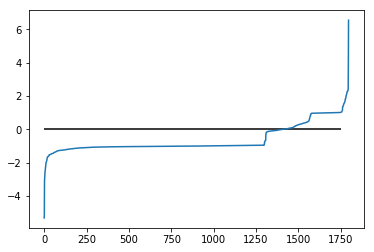

In [55]:
U = [margin_func(ffnn2, x, y) for x, y in zip(Xt, Y)]
U = sorted(U)

plt.plot(U)
plt.hlines(0, 0, 1750)
plt.show()

In [ ]:
result[Q] = {
    'nn':(ffnn0, ffnn1, ffnn2),
    'title':(
        'AM / $r^2$ / %s%%' % Q,
        'AM / $|r|$ / %s%%' % Q,
        'WM$_{%.2f}$ / $r^2$ / %s%%' % (1.1-q, Q) ),
}

In [ ]:
m_q = len(result)
plt.figure(figsize=(12.0, m_q * 3.0))
for j, Q in enumerate(result):
    for i in range(3):
        current = result[Q]
        plt.subplot(m_q, 3, 3*j+i+1)
        _ffnn = current['nn'][i]
        Y1 = np.array([clf_func(_ffnn, x) for x in Xt])
        title = current['title'][i]
        
        image = np.zeros((10,10), 'd')
        for k,l in zip(Y, Y1):
            image[k,l] += 1.0
        plt.title(title)
        plt.plot(0, 9, c='k')
        plt.imshow(image, cmap=plt.cm.gray_r)
        c = sum(Y != Y1) / len(Y) * 100
        plt.ylim(-0.7, 10.8)
        plt.text(0, 10, r'errors: %.1f%%' % c)
        if i == 0:
            plt.ylabel("predicted target")
        else:
            plt.yticks([], [])
        if j == m_q-1:
            plt.xlabel("original target")
        if j < m_q-1:
            plt.xticks([], [])
        #plt.minorticks_on()
plt.tight_layout()
plt.savefig(r"fig/isnn2018_digits_robust_%s.pdf" % n_hidden)
plt.show()